In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
%load_ext autoreload
%autoreload 2
print('TF version:', tf.__version__ , '\nGPU available:', tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
TF version: 2.1.0 
GPU available: True


# MovieLens Dataset

In [2]:
path = '../'
data_path = 'datasets/' # Paperspace
file_name = 'am_like_ml_01'

In [3]:
df = pd.read_pickle(path + data_path + file_name)
df['item_id'] = df.item.astype('category').cat.codes
df['user_id'] = df.user.astype('category').cat.codes
df.head()

,user_id,user,item,datetime,rating,item_id
0,0,A0039616ADOZ0KMWQRNX,B00QFJG1U8,2016-10-04,5.0,87754
1,0,A0039616ADOZ0KMWQRNX,B010ACF2PK,2016-10-04,5.0,104761
2,0,A0039616ADOZ0KMWQRNX,B00BFE0IZ2,2016-10-04,5.0,42989
3,0,A0039616ADOZ0KMWQRNX,B01CZMQCPC,2016-10-04,5.0,127248
4,0,A0039616ADOZ0KMWQRNX,B01B5DLG7G,2016-10-26,4.0,123866


# Init Params

In [4]:
res_ext = file_name[:2]
total_items = len(df.item_id.unique())
first_model_id = str(0) + '_' + res_ext

In [5]:
all_models = pd.read_pickle(path + 'results/' + res_ext + '/all_models_2')
# new_model_id = str(int(all_models.model_id.max()[0]) + 1) + '_' + res_ext

In [6]:
all_models

,model_id,train_time,epochs,BATCH_SIZE,learning_rate,delta,max_seq_len,embedding_dim,rnn_units,val_perc,test_perc,n_items_val,n_items_test,pad_value,shift_targets_by,loss,recall,val_loss,val_recall,test_recall
0,0_am,381.841,5,16,0.10,0.2,18,100,20,0.1,0.1,0,1,135784,1,"[2.554899125704037, 2.531272994767269, 2.42756...","[3.0679382e-06, 0.00013887067, 0.0003541822, 0...","[4.938515297257074, 4.899379484724291, 4.72148...","[7.364693e-05, 0.0002172925, 0.00063066464, 0....",0.009231
1,1_am,380.193,5,16,0.20,0.2,18,100,20,0.1,0.1,0,1,135784,1,"[2.543539660317557, 2.3818412894392247, 2.2508...","[7.198009e-05, 0.0005920039, 0.0021189037, 0.0...","[4.905496847511518, 4.684745960896558, 4.64929...","[0.00020389272, 0.001283496, 0.0029719444, 0.0...",0.006154
2,2_am,384.891,5,16,0.05,0.2,18,100,20,0.1,0.1,0,1,135784,1,"[2.559877950863298, 2.5500924277481776, 2.5402...","[0.0, 3.207008e-06, 9.430675e-05, 0.0001619212...","[4.94934888169317, 4.938912814206416, 4.927669...","[0.0, 5.800284e-05, 0.00010820535, 0.000194552...",0.012308


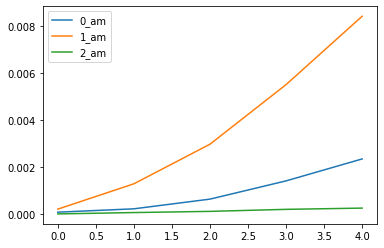

In [7]:
for value in all_models['val_recall'][:3]:
    plt.plot(value)
    plt.legend(all_models['model_id'])
plt.show()

In [8]:
params = {
'model_id':first_model_id,
'train_time':0,
'epochs':0,

# Grid Search params
'BATCH_SIZE':32,
'learning_rate':0.1,
'delta':0.2,             # Diversity Bias
'max_seq_len':30,        # Max length of sequence71=median
'embedding_dim':100,
'rnn_units':20,
    
'val_perc':0.1,          # Percentage of users from df in val and test set
'test_perc':0.1, 
'n_items_val':0,        # Number of last (chronologically) items in val and test set
'n_items_test':1,

'pad_value':total_items, # Pad with total_items+1 => masked => still use item 0
'shift_targets_by':1  
}

In [9]:
BATCH_SIZE = params['BATCH_SIZE']
learning_rate = params['learning_rate']
delta = params['delta']
max_seq_len = params['max_seq_len']

val_perc = params['val_perc']
test_perc = params['test_perc']
n_items_val = params['n_items_val']
n_items_test = params['n_items_test']

pad_value = params['pad_value']
shift_targets_by = params['shift_targets_by'] 

embedding_dim = params['embedding_dim']
rnn_units = params['rnn_units']

# Imports

In [12]:
from Data_prep import train_val_test_split, create_seq_batch_dataset
from Models import build_LSTM_model, store_LSTM_model
from Evaluation import recall_metric, diversity_bias_loss, create_diversity_bias, get_predictions, get_metrics
from Helpers import TimingCallback
import time

# Init Datasets

In [13]:
# Train Test Val Split
data_split = train_val_test_split(df, val_perc, test_perc, n_items_val, n_items_test, seqs=True)
train_set, val_set, val_left_out_items, test_set, test_left_out_items = data_split 

# Configure Checkpoint directory

BPR.ipynb	 CF_RNN_old.ipynb  Helpers.py	benchmarks.ipynb
BPR_TF.ipynb	 Data_prep.py	   Models.py	core
CF_RNN.ipynb	 Evaluation.py	   README.md	data_used.ipynb
CF_RNN_GS.ipynb  Full_model.ipynb  __pycache__	visualize_results.ipynb


In [14]:
ext = '_' + file_name[:2] #ML or Am
# directory = './ckpts/ckpts' 
directory = '../ckpts/ckpts'

---
# Grid Search

In [15]:
learning_rates = [0.1, 0.2]
epochs = [1]
deltas = [0.2, 0.5]
batch_sizes = [16, 32]
max_seq_lens = [18, 30] #Median=18
rnn_units = [20, 50]

rank_at = 20
test_batch_size = 1024

total_runs = len(learning_rates) * len(epochs) * len(deltas) * len(batch_sizes) * len(max_seq_lens) * len(rnn_units)
runs = 0
print(f'Total runs: {total_runs}')

Total runs: 32


In [16]:
metrics=[recall_metric(total_items=total_items)]
for epoch in epochs:
    params['epochs'] = epoch
    for delta in deltas:
        params['delta'] = delta
        
        # Pre-Calculate diversity_bias
        diversity_bias = create_diversity_bias(train_set, total_items, delta)
        loss=diversity_bias_loss(db=diversity_bias, total_items=total_items)
        
        for rnn_unit in rnn_units:
            params['rnn_units'] = rnn_unit
        
            for batch_size in batch_sizes:
                params['BATCH_SIZE'] = batch_size
                
                # Rebuild model 
                model = build_LSTM_model(total_items = total_items, embedding_dim = embedding_dim, mask_value = pad_value, rnn_units = rnn_unit, batch_size = batch_size, return_sequences=True)

                for max_seq_len in max_seq_lens:
                    params['max_seq_len'] = max_seq_len

                    # Create new datasets
                    train_dataset = create_seq_batch_dataset(df=train_set, shift=shift_targets_by, max_seq_len=max_seq_len, pad_value=pad_value, batch_size=batch_size, stats=False, drop_remainder=True)
                    val_dataset = create_seq_batch_dataset(df=val_set, shift=shift_targets_by, max_seq_len=max_seq_len, pad_value=pad_value, batch_size=batch_size, stats=False, drop_remainder=True) 

                    for learning_rate in learning_rates:
                        runs += 1
                        s = time.time()

                        # Print current run
                        print('='*50, '\nRun:', str(runs) + '/' + str(total_runs))
                        print('Number of epochs:\t', epoch)
                        print('Number of (h) units:\t', rnn_unit)
                        print('Batch size:\t\t', batch_size)
                        print('Max seq len:\t\t', max_seq_len)
                        print('Learning rate:\t\t', learning_rate)

                        params['learning_rate'] =  learning_rate

                        # Compile Model
                        model = build_LSTM_model(total_items = total_items, embedding_dim = embedding_dim, mask_value = pad_value, rnn_units = rnn_unit, batch_size = batch_size, return_sequences=True)
                        optimizer=tf.keras.optimizers.Adagrad(lr=learning_rate)

                        model.compile(optimizer=optimizer,
                                      loss=loss, 
                                      metrics=metrics)

                        # Create Callbacks
                        checkpoint_dir = directory + '_' + str(params['model_id'])
                        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
                        
                        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_prefix, monitor = 'val_recall', mode = 'max', save_best_only = True, save_weights_only = True)
                        early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_recall', min_delta = 0.0001, mode = 'max', patience = 15)
                        timing_callback = TimingCallback()
                        callbacks = [checkpoint_callback, early_stopping_callback, timing_callback]
                        
                        # Run 
                        history = model.fit(x=train_dataset, 
                                            validation_data=val_dataset, 
                                            epochs=epoch,
                                            callbacks=callbacks,
                                            verbose=1)
                        
                        
                        # Restore lates checkpoint and predict 
                        model = build_LSTM_model(total_items = total_items, embedding_dim = embedding_dim, mask_value = pad_value, rnn_units = rnn_unit, batch_size = None, return_sequences=False)
                        model.load_weights(tf.train.latest_checkpoint(checkpoint_dir)).expect_partial()
                        model.build(tf.TensorShape([1, None]))
                        preds_df = get_predictions(model, test_set, test_left_out_items, test_batch_size, max_seq_len, pad_value, rank_at)
                        metrics_test = get_metrics(preds_df, 5, rank_at, stats=False)
#                         print(metrics_test)
                        
                        # Store model
                        store_path = path + 'results/' + res_ext + '/all_models_2'
                        train_time = np.sum(timing_callback.logs)
                        all_models = store_LSTM_model(store_path, params.copy(), history.history.copy(), train_time, metrics_test, store=True)
                        
                        # Change Model Id for next model
                        params['model_id'] = str(int(params['model_id'][0]) + 1) + '_am'
                        print(f'Run Time: {time.time() - s}')


Run: 1/32
Number of epochs:	 150
Number of (h) units:	 20
Batch size:		 16
Max seq len:		 18
Learning rate:		 0.1
Train for 812 steps, validate for 101 steps
Epoch 1/150
812/812 [==============================] - 36s 44ms/step - loss: 2.5549 - recall: 3.5005e-06 - val_loss: 4.9384 - val_recall: 7.9604e-05
Epoch 2/150
812/812 [==============================] - 28s 35ms/step - loss: 2.5278 - recall: 1.4902e-04 - val_loss: 4.8876 - val_recall: 2.2340e-04
Epoch 3/150
812/812 [==============================] - 29s 35ms/step - loss: 2.4053 - recall: 4.1582e-04 - val_loss: 4.7131 - val_recall: 7.7271e-04
Epoch 4/150
812/812 [==============================] - 29s 35ms/step - loss: 2.2867 - recall: 0.0011 - val_loss: 4.6787 - val_recall: 0.0015
Epoch 5/150
812/812 [==============================] - 28s 35ms/step - loss: 2.2543 - recall: 0.0019 - val_loss: 4.6596 - val_recall: 0.0024
Epoch 6/150
812/812 [==============================] - 29s 35ms/step - loss: 2.2334 - recall: 0.0028 - val_loss: 

KeyboardInterrupt: 

Speed with test_batch_size:
- 1    => +- 1500 sec
- 1024 => 